In [49]:
# Some imports that you might need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
import nltk
import os

# Switch PyTorch to GPU compute
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using:", device)

We're using: cuda


Hi Jack

For the data, you can click download at
https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

You can choose to store the data in your google drive and mount your drive for accessing them from the following cell.

In [50]:
# from google.colab import drive
# drive.mount('/content/drive')

Or you can download it by the following cell:

In [51]:
!pip install --upgrade --no-cache-dir gdown
if not os.path.exists("Reviews.csv"):
    !gdown 1_kLSwiRYtiXF7h9V1FlTqTapOHiYU5Mk

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [52]:
# Remeber to change the path here for the corresponding files you need
df = pd.read_csv('Reviews.csv')
print(df.shape)
# df = df.head(500000)
print(df.shape)

(568454, 10)
(568454, 10)


In [53]:
# df.head()
# df = df[df["Score"] == 3]

entries = 29000

df5 = df[df["Score"] == 5]
df5 = df5.head(entries)
df4 = df[df["Score"] == 4]
df4 = df4.head(entries)
df3 = df[df["Score"] == 3]
df3 = df3.head(entries)
df2 = df[df["Score"] == 2]
df2 = df2.head(entries)
df1 = df[df["Score"] == 1]
df1 = df1.head(entries)

df = pd.concat([df1, df2, df3, df4, df5])
df.Score.value_counts()

1    29000
2    29000
3    29000
4    29000
5    29000
Name: Score, dtype: int64

In [54]:
# import libraries for preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment import SentimentAnalyzer
from sklearn.preprocessing import MultiLabelBinarizer
from string import punctuation
from string import digits
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [55]:
# function to remove stop words
eng_stopwords = stopwords.words('english') 
def filter_words(alist):
  ret_l = []
  for w in alist:
    for el in w:
        if el in punctuation:
          w = w.replace(el,"")
    if w.lower() not in eng_stopwords and w not in punctuation and w != '...' and w !='br' and w not in digits and w != 'nt':
      ret_l.append(w.lower())
  return ret_l

In [56]:
# preprocess data

df['tokenized_text'] = df['Text'].apply(word_tokenize)
df['filtered_text'] = df['tokenized_text'].apply(filter_words)
all_reviews = df['filtered_text'].tolist()
all_words=[element for sublist in all_reviews for element in sublist]
total_words=len(all_words)
count_words = Counter(all_words)



In [57]:
from sklearn.feature_extraction.text import CountVectorizer

def bag_of_words_encode(column):
    # Create a CountVectorizer object with max_features set to 2000
    vectorizer = CountVectorizer(max_features=2000)

    # Join the lists of words into strings
    column_str = column.apply(lambda x: ' '.join(x))

    # Fit the CountVectorizer on the strings
    vectorizer.fit(column_str)

    # Transform the CountVectorizer on the strings
    X = vectorizer.transform(column_str)

    # Create a pandas DataFrame of the encoded features
    df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

    return df


In [58]:
# put this in a word cloud
print(df['filtered_text'])
# sorted_words=count_words.most_common(total_words)
# sorted_words = sorted_words[:2000]
# print(sorted_words[:10])

1        [product, arrived, labeled, jumbo, salted, pea...
12       [cats, happily, eating, felidae, platinum, two...
26       [candy, red, flavor, plan, chewy, would, never...
50       [oatmeal, good, mushy, soft, like, quaker, oat...
62                [arrived, days, stale, could, eat, bags]
                               ...                        
46500    [add, water, shazaam, peanut, butter, stuff, t...
46501    [far, best, choice, low, fat, option, peanut, ...
46506    [peanut, butter, one, things, reluctantly, gav...
46507    [watching, calorie, intake, reading, reviews, ...
46508    [love, pb2, add, chocolate, protein, smoothies...
Name: filtered_text, Length: 145000, dtype: object


In [139]:
encoded_df = bag_of_words_encode(df['filtered_text'])
print(df.shape)
print(encoded_df.shape)
# print(encoded_df.iloc(0))


(145000, 12)
(145000, 2000)
(145000, 2012)
[False False False ... False False False]


In [140]:
full_df = pd.concat([encoded_df.reset_index(drop=True), df.reset_index(drop=True)], axis=1)
print(full_df.shape)
print(full_df.isna().any().values)

(145000, 2012)
[False False False ... False False False]


In [143]:
for val in full_df.isna().any().values:
    if val:
        print("shit")

shit
shit


In [12]:
# one hot encode the words
# vocab_to_int={w:i+1 for i,(w,c) in enumerate(sorted_words)}
# print(vocab_to_int)


In [13]:
# # transform reviews into lists of numbers
# e_rev = []
# for review in all_reviews:
#   e = []
#   for word in review:
#     if word not in vocab_to_int.keys():
#       e.append(0)
#     else:
#       e.append(vocab_to_int[word])
#   e_rev.append(e)

In [14]:
# make the feature array and make the inputs all the same length
# length = 300
# feats=np.zeros((len(e_rev), length), dtype=int)

# for i, rev in enumerate(e_rev):
#   if len(rev) > length:
#     feats[i,:] = np.array(rev[:length])
#   else:
#     for j in range(len(rev)):
#       feats[i,j] = rev[j]
# # X_train
# feats
feats = encoded_df.to_numpy()

In [15]:
# feature training
# df['Score']
labels = df['Score'].array
# y_train
# labels = labels / 5

# labels = labels.to_numpy()

print(labels.shape)
print(feats.shape)
# feats = feats.T
data = np.column_stack((feats, labels))
data = data.astype(float)
transform = transforms.Compose([transforms.ToTensor()])

data = transform(data)
data = torch.squeeze(data, dim=0)
print(data.shape)

(145000,)
(145000, 2000)
torch.Size([145000, 2001])


In [16]:
# Split into Train, Validation, Test

feats = data[:, :-1]
labels = data[:, -1]
labels = F.one_hot(labels.to(torch.int64), num_classes=6)

labels = labels[:, 1:]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feats, labels, test_size=0.25, random_state=42)
# train_x=feats[:int(0.8*len(feats))]
# train_y=labels[:int(0.8*len(feats))]
# valid_x=feats[int(0.8*len(feats)):int(0.9*len(feats))]
# valid_y=labels[int(0.8*len(feats)):int(0.9*len(feats))]
# test_x=feats[int(0.9*len(feats)):]
# test_y=labels[int(0.9*len(feats)):]
# print(train_x.shape, valid_y.shape, test_x.shape)


In [17]:
# Split the Dataset

# train_dataset = TensorDataset(torch.FloatTensor(train_x), torch.FloatTensor(train_y))
# valid_dataset = TensorDataset(torch.FloatTensor(valid_x), torch.FloatTensor(valid_y))
# test_dataset = TensorDataset(torch.FloatTensor(test_x), torch.FloatTensor(test_y))

train_dataset = TensorDataset(torch.LongTensor(X_train.numpy()), torch.LongTensor(y_train.numpy()))
# valid_dataset = TensorDataset(torch.tensor(valid_x), torch.tensor(valid_y))
test_dataset = TensorDataset(torch.LongTensor(X_test.numpy()), torch.LongTensor(y_test.numpy()))

batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_dataset))
print(len(test_dataset))

108750
36250


In [18]:
# Feed Forward Neural Network Class
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Create the layers of CNN here -- Currently from HW5 so may want to change to tune

        # Convolutional Layers & Pooling
        # self.embedding = nn.Embedding(2001, 350)
        # self.conv1 = nn.Conv1d(350, 50, 7)
        # self.conv2 = nn.Conv1d(12, 3, 3, padding=1)
        # self.conv3 = nn.Conv1d(batch_size, batch_size, 3)
        # self.pool = nn.MaxPool1d(3)
        self.fc4 = nn.Linear(2000, 1000)
        # self.fc1 = nn.Linear(350, 500)
        # self.fc3 = nn.Linear(500, 400)
        # self.fc2 = nn.Linear(400, 300)
        self.fchidden = nn.Linear(1000, 400)
        self.fc3 = nn.Linear(400, 5)
        self.dropout = nn.Dropout(0.5)
        # self.dropoutconv = nn.Dropout(0.1)
        self.relu = nn.ReLU()


        # STUDENT TODO END

    def forward(self, x):
        # Perform the forward pass through the layers -- also still from HW5
        # x = self.embedding(x)
        # x = torch.transpose(x, 2, 1)

        # x = self.pool(
        #     self.relu(self.conv1(x))
        #     )
        # x = self.pool(self.relu(self.conv2(x)))
        x = self.fc3(self.relu(self.fchidden(self.dropout(self.relu(self.fc4(x))))))
        # x = torch.mean(x, 1)
        return x

# Create an instance of Net and move it to the GPU
model = Net()
model.to(device)

Net(
  (fc4): Linear(in_features=2000, out_features=1000, bias=True)
  (fchidden): Linear(in_features=1000, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [19]:
# 1. Set the criterion to be cross entropy loss
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()

# 2. Experiment with different optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
# torch.backends.cudnn.enabled = False

In [20]:
train_loss, validation_loss = [], []
train_acc, validation_acc = [], []

# Note that we have set the number of epochs to be 10. You can choose to increase or decrease the number of epochs.
num_epochs = 750
for epoch in range(num_epochs):
    
    model.train()
    running_loss = 0.
    correct, total = 0, 0 
    
    for i, data in enumerate(train_dataloader, 0):

        inputs, labels = data
        # print(labels)
        # labels = labels.type(torch.LongTensor)
        # 1. Store the inputs and labels in the GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(inputs[0])

        # 2. Get the model predictions
        # print(inputs)
        predictions = model(inputs.float())
        # print(predictions)
        
        # 3. Zero the gradients out
        optimizer.zero_grad()

        # 4. Get the loss
        # print(predictions.shape)
        # print(labels.shape)
        # print(predictions)
        # print(labels)
        loss = criterion(predictions[0], labels[0].float())

        # 5. Calculate the gradients
        loss.backward()

        # 6. Update the weights
        optimizer.step()
            
        running_loss += loss.item()

        predicted = predictions

        # print("predicted: ", torch.max(predictions, dim=1).indices)
        # print("labels: ", labels)

        # _, predicted = torch.max(predictions, 1)
        total += labels.size(0)
        # print((torch.max(predictions, dim=1).indices == torch.max(labels,dim=1).indices))
        # print((torch.max(predictions, dim=1).indices == torch.max(labels,dim=1).indices).sum().item())
        correct += (torch.max(predictions, dim=1).indices == torch.max(labels,dim=1).indices).sum().item()
        
    train_loss.append(running_loss / len(train_dataloader))
    train_acc.append(correct/total)
            
    model.eval()
    running_loss = 0.
    correct, total = 0, 0 
    
    # for i, data in enumerate(val_dataloader, 0):

    #     inputs, labels = data
    #     # labels = labels.type(torch.LongTensor)
    #     # 1. Store the inputs and labels in the GPU
    #     inputs = inputs.to(device)
    #     labels = labels.to(device)
        
    #     # 2. Get the model predictions
    #     predictions = model(inputs.float())

        
    #     # 3. Zero the gradients out
    #     optimizer.zero_grad()

    #     # 4. Get the loss
        
    #     # print(predictions.shape)
    #     # print(labels.shape)

    #     loss = criterion(predictions[0], labels[0].float())

    #     running_loss += loss.item()

    #     predicted = predictions

        
    #     # _, predicted = torch.max(predictions, 1)
    #     total += labels.size(0)
    #     correct += (torch.max(predictions, dim=1).indices == torch.max(labels,dim=1).indices).sum().item()
        
    # validation_loss.append(running_loss / len(val_dataloader))
    # validation_acc.append(correct/total)

    print(f"Epoch {epoch+1}:")

    print(f"Training Loss:", round(train_loss[epoch], 3))
    # print(f"Validation Loss:", round(validation_loss[epoch], 3))
    
    print(f"Training Accuracy:", round(train_acc[epoch], 3))
    # print(f"Validation Accuracy:", round(validation_acc[epoch], 3))

    print("------------------------------")

Epoch 1:
Training Loss: 1.502
Training Accuracy: 0.34
------------------------------
Epoch 2:
Training Loss: 1.381
Training Accuracy: 0.403
------------------------------


KeyboardInterrupt: 

In [39]:
from logging import exception
model = torch.load('./FNN_750_epochs.pt')
model.eval()

test_predictions = np.array([])
test_labels = np.array([])
correct, total = 0, 0 

for i, data in enumerate(test_dataloader, 0):

    inputs, labels = data

    # STUDENT TODO START:
    # 1. Store the inputs in the GPU
    inputs = inputs.to(device)
    
    # 2. Get the model predictions
    predictions = model(inputs.float())
    # STUDENT TODO END

    predicted = torch.max(predictions, 1).indices

    test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
    test_labels = np.concatenate((test_labels, (torch.max(labels,dim=1).indices).cpu().numpy()))
    total += labels.size(0)
    correct += (torch.max(predictions, dim=1).indices.cpu() == torch.max(labels,dim=1).indices.cpu()).sum().item()
    acc = correct/total

Text(0.5, 1.0, 'confusion matrix of classifer')

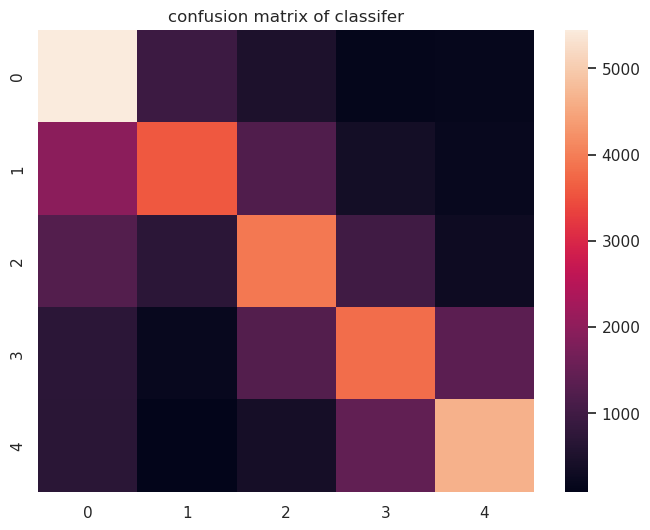

In [40]:
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
conf = metrics.confusion_matrix(test_labels, test_predictions)
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(conf)
plt.title('confusion matrix of classifer')

In [41]:
# for i in test_predictions:
#   print(i+1)
print(acc)

0.5900413793103448


In [42]:
# plt.plot(range(num_epochs), train_acc)
# plt.title("Training Accuracy vs. Number of Epochs")
# plt.xlabel("Elapsed epochs")
# plt.ylabel("Training Accuracy")
# plt.show()

In [43]:
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def eval(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')
  cm = confusion_matrix(y_true, y_pred)

  print("Accuracy: {:.2f}".format(accuracy))
  print("Precision: {:.2f}".format(precision))
  print("Recall: {:.2f}".format(recall))
  print("F1 Score: {:.2f}".format(f1))

  plt.figure(figsize=(4, 4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", square=True, linewidths=0.01, linecolor="gray")
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title("Confusion Matrix")
  plt.show()

Accuracy: 0.59
Precision: 0.60
Recall: 0.59
F1 Score: 0.59


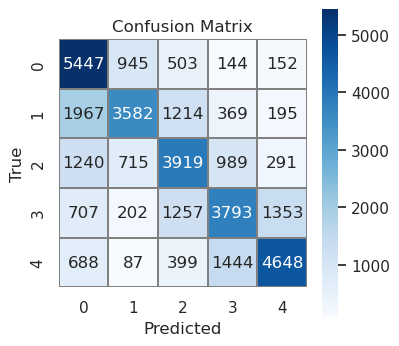

In [44]:
eval(test_labels, test_predictions)

**Dataset Shift**

In [26]:
# df = pd.read_csv('Reviews.csv')
# print(df.shape)
# df = df
# print(df.shape)

# df.head()

# print(df['HelpfulnessNumerator'].unique())
# print(df['HelpfulnessNumerator'].unique().shape)

# shift_df_0 = df[df['HelpfulnessNumerator'] == 0]
# shift_df_1 = df[df['HelpfulnessNumerator'] != 0]

# # encode features for helpfulness numerator = 0

# shift_df_0['tokenized_text'] = shift_df_0['Text'].apply(word_tokenize)
# shift_df_0['filtered_text'] = shift_df_0['tokenized_text'].apply(filter_words)
# encoded_df_0 = bag_of_words_encode(shift_df_0['filtered_text'])
# feats_0 = encoded_df_0.to_numpy()

# # encode features for helpfulness numerator > 0

# shift_df_1['tokenized_text'] = shift_df_1['Text'].apply(word_tokenize)
# shift_df_1['filtered_text'] = shift_df_1['tokenized_text'].apply(filter_words)
# encoded_df_1 = bag_of_words_encode(shift_df_1['filtered_text'])
# feats_1 = encoded_df_1.to_numpy()


# df['tokenized_text'] = df['Text'].apply(word_tokenize)
# df['filtered_text'] = df['tokenized_text'].apply(filter_words)
# encoded_df = bag_of_words_encode(df['filtered_text'])


# feats = encoded_df.to_numpy()

# # feature training for helpfulness numerator = 0
# labels_0 = shift_df_0['Score'].array

# data_0 = np.column_stack((feats_0, labels_0))
# data_0 = data_0.astype(float)
# transform = transforms.Compose([transforms.ToTensor()])

# data_0 = transform(data_0)
# data_0 = torch.squeeze(data_0, dim=0)
# print(data_0.shape)

# feats_0 = data_0[:, :-1]
# labels_0 = data_0[:, -1]
# labels_0 = F.one_hot(labels_0.to(torch.int64), num_classes=6)

# labels_0 = labels_0[:, 1:]

# # feature training for helpfulness numerator > 0

# labels_1 = shift_df_1['Score'].array

# data_1 = np.column_stack((feats_1, labels_1))
# data_1 = data_1.astype(float)
# transform = transforms.Compose([transforms.ToTensor()])

# data_1 = transform(data_1)
# data_1 = torch.squeeze(data_1, dim=0)
# print(data_1.shape)

# feats_1 = data_1[:, :-1]
# labels_1 = data_1[:, -1]
# labels_1 = F.one_hot(labels_1.to(torch.int64), num_classes=6)

# labels_1 = labels_1[:, 1:]



(568454, 10)
(568454, 10)
[  1   0   3   4   2  19  13   9  15   5  17   8   6   7  43  14  11  20
  27  12  10  16  21  26  23 165  45  30 100  32  24  22  18  59 187  29
 112 107  51  36  25  88  35  38  42  70  86  48  34  96  53  40  31  65
 128  97  82  37  28 202  47 149  80  77  69  56  39 111  60  66  44  91
 115  93 180 129  58  83  55  62  89  50  33 135  71 157  73 122  90  81
 203 168  64  61 398 206 133  41  84  63  95  68 110  57  72  52  54  49
 177  46 137 286  87 264  85 258  75 119 123 131 125 200 536 301  78 559
 472 232 294  79  67 154 105  74 117 113 141 162 349 130 230 189 454 172
 116 179 138 166 142 170 247 366 106 219  94  76  92 413 139 866 524 233
 104 844  99 144 124 491 355 121 192 580 102 155 436 446 262 319 103 356
 439 346 193 274 466 354 152 429 120 538 178 257 212 205 108 153 278 164
 158 126 406 290 150 488 303 147 209 218 143 146 148 151 118 145 253 169
 159 174 114 204 227 207 199 321 223 101 109 281 231 188 808]
(231,)


/tmp/ipykernel_32606/2985785660.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_df_0['tokenized_text'] = shift_df_0['Text'].apply(word_tokenize)
/tmp/ipykernel_32606/2985785660.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shift_df_0['filtered_text'] = shift_df_0['tokenized_text'].apply(filter_words)
/tmp/ipykernel_32606/2985785660.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

torch.Size([303826, 2001])
torch.Size([264628, 2001])


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)


tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)


tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)


tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(1)
tensor(0)
tensor(1)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(1)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [169]:
num0 = full_df[full_df['HelpfulnessNumerator'] == 0] 
num0 = num0[num0['HelpfulnessDenominator'] > 5]
num1 = full_df[full_df['HelpfulnessNumerator'] > 50]

num0_feats = num0.drop(['Id', "ProductId", "UserId", "ProfileName", "HelpfulnessNumerator",
                        "HelpfulnessDenominator", "Score", "Time", "Summary", "Text", 'tokenized_text',
                        'filtered_text'], axis=1)
# num0_feats = num0.drop(columns=num0.columns[-12:], axis=1)
num0_labels = num0['Score'].array

data = np.column_stack((num0_feats, num0_labels))
data = data.astype(float)
transform = transforms.Compose([transforms.ToTensor()])
data = transform(data)
data = torch.squeeze(data, dim=0)

feats0 = data[:, :-1]
labels = data[:, -1]
labels.to(torch.int64)
labels = F.one_hot(labels.to(torch.int64), num_classes = 6)
num0_labels = labels[:, 1:]


num1_feats = num1.drop(['Id', "ProductId", "UserId", "ProfileName", "HelpfulnessNumerator",
                        "HelpfulnessDenominator", "Score", "Time", "Summary", "Text", 'tokenized_text', 'filtered_text'], axis=1)
# num1_feats = num1.drop(columns=num1.columns[-12:], axis=1)
num1_labels = num1['Score'].array

data = np.column_stack((num1_feats, num1_labels))
data = data.astype(float)
transform = transforms.Compose([transforms.ToTensor()])
data = transform(data)
data = torch.squeeze(data, dim=0)

feats1 = data[:, :-1]
labels = data[:, -1]

labels = F.one_hot(labels.to(torch.int64), num_classes = 6)
num1_labels = labels[:, 1:]

print(feats0.size())
print(num0_labels.size())


test_dataset_0 = TensorDataset(torch.LongTensor(feats0.numpy()), torch.LongTensor(num0_labels.numpy()))
test_dataset_1 = TensorDataset(torch.LongTensor(feats1.numpy()), torch.LongTensor(num1_labels.numpy()))

batch_size = 50

test_dataloader_0 = DataLoader(test_dataset_0, batch_size=batch_size, shuffle=False)
test_dataloader_1 = DataLoader(test_dataset_1, batch_size=batch_size, shuffle=False)

# print(len(train_dataset))
print(len(test_dataset_0))
print(len(test_dataset_1))

torch.Size([808, 2000])
torch.Size([808, 5])
808
346


In [170]:
from logging import exception
model = torch.load('./FNN_750_epochs.pt')
model.eval()

test_predictions = np.array([])
test_labels = np.array([])
correct, total = 0, 0 

for i, data in enumerate(test_dataloader_0, 0):

    inputs, labels = data

    # STUDENT TODO START:
    # 1. Store the inputs in the GPU
    inputs = inputs.to(device)
    
    # 2. Get the model predictions
    predictions = model(inputs.float())

    predicted = torch.max(predictions, 1).indices
    
    test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
    test_labels = np.concatenate((test_labels, (torch.max(labels,dim=1).indices).cpu().numpy()))
    total += labels.size(0)
    correct += (torch.max(predictions, dim=1).indices.cpu() == torch.max(labels,dim=1).indices.cpu()).sum().item()
    acc = correct/total

Accuracy: 0.75
Precision: 0.77
Recall: 0.75
F1 Score: 0.75


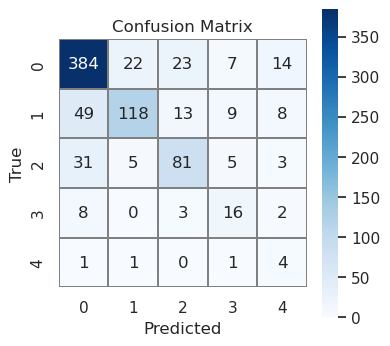

In [171]:
eval(test_labels, test_predictions)

Helpfulness Numerator = 0, Denominator > 5

In [167]:
from logging import exception
model = torch.load('./FNN_750_epochs.pt')
model.eval()

test_predictions = np.array([])
test_labels = np.array([])
correct, total = 0, 0 

for i, data in enumerate(test_dataloader_1, 0):

    inputs, labels = data

    # STUDENT TODO START:
    # 1. Store the inputs in the GPU
    inputs = inputs.to(device)
    
    # 2. Get the model predictions
    predictions = model(inputs.float())
    # STUDENT TODO END

    predicted = torch.max(predictions, 1).indices

    test_predictions = np.concatenate((test_predictions, predicted.detach().cpu().numpy()))
    test_labels = np.concatenate((test_labels, (torch.max(labels,dim=1).indices).cpu().numpy()))
    total += labels.size(0)
    correct += (torch.max(predictions, dim=1).indices.cpu() == torch.max(labels,dim=1).indices.cpu()).sum().item()
    acc = correct/total

Accuracy: 0.74
Precision: 0.77
Recall: 0.74
F1 Score: 0.74


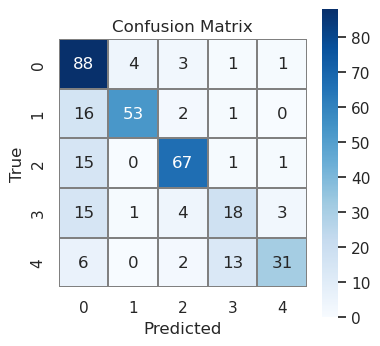

In [168]:
eval(test_labels, test_predictions)

Helpfulness > 50